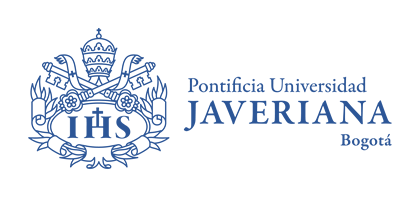

# **Lab 1**

### **Summary:**

The following notebook has the purpose of doing:

- A **feature selection** of the quantitative data.


# **Libraries**

In [ ]:
# !pip install facets-overview

In [6]:
!python --version

Python 3.7.12


In [44]:
# Basic Libraries
import pandas as pd

# Feature selection Libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#
import tfx
import tensorflow_data_validation as tfdv
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.components import CsvExampleGen
from tfx.components import StatisticsGen
from tfx import proto
from tensorflow_metadata.proto.v0 import schema_pb2
from tfx import v1 as tfx

#
# from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML

# **Reading Data**

In [2]:
data = pd.read_csv("../data/covertype/covertype_train.csv")
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2991,119,7,67,11,1015,233,234,133,1570,Commanche,C7202,1
1,2876,3,18,485,71,2495,192,202,144,1557,Commanche,C7757,1
2,3171,315,2,277,9,4374,213,237,162,1052,Rawah,C7745,0
3,3087,342,13,190,31,4774,193,221,166,752,Rawah,C7745,0
4,2835,158,10,212,41,3596,231,242,141,3280,Rawah,C4744,1


Split data in y and X

In [3]:
y = data['Cover_Type']
X = data.drop(columns = 'Cover_Type')

# **Feature Selection**

First we split the categorical with the numerical variables

In [4]:
# Identify the column types
categorical_columns = X.select_dtypes(exclude = [int, float]).columns
numerical_columns = X.select_dtypes(include = [int, float]).columns

Creating subgruops for further analysis

In [5]:
numerical_X = X[numerical_columns]
categorical_X = X[categorical_columns]
print(f"Original shape of the numerical variables: {numerical_X.shape}")
print(f"Original shape of the categorical variables: {categorical_X.shape}")

Original shape of the numerical variables: (116203, 10)
Original shape of the categorical variables: (116203, 2)


Run the feature selection

In [6]:
# Selecting the best 8 variables
new_numerical_X = SelectKBest(f_classif, k=8).fit_transform(numerical_X, y) 
print(f"New shape of the numerical variables: {new_numerical_X.shape}")

New shape of the numerical variables: (116203, 8)


Let's see the final numerical variables

In [7]:
feature_selection = {"Columns": [], "Retain": []}
final_numerical_columns = []
idx=0
for column in numerical_X.columns:
    if new_numerical_X[0, idx] == numerical_X[column][0]:
        feature_selection["Columns"].append(column)
        feature_selection["Retain"].append(True)
        final_numerical_columns.append(column)
        idx+=1
    else:
        feature_selection["Columns"].append(column)
        feature_selection["Retain"].append(False)
# Assigning actual column names to new numerical X
new_numerical_X = pd.DataFrame(new_numerical_X, columns=final_numerical_columns)
# Identifing columns that will remain in the lab
pd.DataFrame(feature_selection)

,Columns,Retain
0,Elevation,True
1,Aspect,False
2,Slope,True
3,Horizontal_Distance_To_Hydrology,True
4,Vertical_Distance_To_Hydrology,True
5,Horizontal_Distance_To_Roadways,True
6,Hillshade_9am,True
7,Hillshade_Noon,True
8,Hillshade_3pm,False
9,Horizontal_Distance_To_Fire_Points,True


# **Data Pipeline**

## _Generate Examples_

In [8]:
# Inicializa el contexto interactivo de TFX
context = InteractiveContext(pipeline_root = "pipeline")

First we need to export the actual dataset to csv

In [75]:
final_df = pd.concat([new_numerical_X, categorical_X, y], axis=1)
final_df.to_csv("../data/data_modified/covertype_train_v2.csv", index=False)

Now we run the ExampleGen

In [77]:
output = proto.example_gen_pb2.Output(
             split_config=proto.example_gen_pb2.SplitConfig(splits=[
                 proto.example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=3),
                 proto.example_gen_pb2.SplitConfig.
                 Split(name='eval', hash_buckets=1)
             ]))
example_gen = CsvExampleGen(input_base='../data/data_modified', output_config=output)
context.run(example_gen)
# example_gen

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 27
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

## _Statistics_

Now we generate the statistics from example_gen

In [78]:
statistics_gen = StatisticsGen(
      examples=example_gen.outputs['examples']
      )
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 28
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

Let's search where those statistics were stored

In [79]:
# File location where stats were saved
output_dir = statistics_gen.outputs['statistics'].get()[0].uri
print(f"Stats have been stored in: {output_dir}")


Stats have been stored in: pipeline/StatisticsGen/statistics/28


Let's visualize the stats

In [80]:
context.show(statistics_gen.outputs['statistics'])

## _Infer Schema_

Now, we need to validate the datasets

In [81]:
schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=True
)
context.run(schema_gen)
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Cover_Type',INT,required,,-
'Elevation',INT,required,,-
'Hillshade_9am',INT,required,,-
'Hillshade_Noon',INT,required,,-
'Horizontal_Distance_To_Fire_Points',INT,required,,-
'Horizontal_Distance_To_Hydrology',INT,required,,-
'Horizontal_Distance_To_Roadways',INT,required,,-
'Slope',INT,required,,-
'Soil_Type',STRING,required,,'Soil_Type'


,Values
Domain,
'Soil_Type',"'C2702', 'C2703', 'C2704', 'C2705', 'C2706', 'C2717', 'C3501', 'C3502', 'C4201', 'C4703', 'C4704', 'C4744', 'C4758', 'C5101', 'C5151', 'C6101', 'C6102', 'C6731', 'C7101', 'C7102', 'C7103', 'C7201', 'C7202', 'C7700', 'C7701', 'C7702', 'C7709', 'C7710', 'C7745', 'C7746', 'C7755', 'C7756', 'C7757', 'C7790', 'C8703', 'C8707', 'C8708', 'C8771', 'C8772', 'C8776'"
'Wilderness_Area',"'Cache', 'Commanche', 'Neota', 'Rawah'"


## _Modifying Schema_

First we need to create a schema as a "Schema Proto" to be able to be read with **tfdv** and later we can be able to use the following functions

In [82]:
SCHEMA_FILE_NAME = schema_gen.outputs['schema'].get()[0].uri + '/schema.pbtxt'
schema = tfdv.load_schema_text(SCHEMA_FILE_NAME)

Now we update the domain of each feature

In [83]:
# Set Hillshade_9am frm 0 to 255
tfdv.set_domain(schema, "Hillshade_9am", schema_pb2.IntDomain(name="Hillshade_9am", min=0, max=255))
# Set Hillshade Noon from 0 to 255
tfdv.set_domain(schema, "Hillshade_Noon", schema_pb2.IntDomain(name="Hillshade_Noon", min=0, max=255))
# Set Slope from 0 to 90
tfdv.set_domain(schema, "Slope", schema_pb2.IntDomain(name="Slope", min=0, max=90))
# Set Cover_Type
## First we need to change the data type
schema.feature[0].type = 1 # String
## Then we can set the actual labels
tfdv.set_domain(schema, "Cover_Type", schema_pb2.StringDomain(name="Cover_Type", value=['0', '1', '2', '3', '4', '5', '6']))

tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Cover_Type',STRING,required,,'Cover_Type'
'Elevation',INT,required,,-
'Hillshade_9am',INT,required,,min: 0; max: 255
'Hillshade_Noon',INT,required,,min: 0; max: 255
'Horizontal_Distance_To_Fire_Points',INT,required,,-
'Horizontal_Distance_To_Hydrology',INT,required,,-
'Horizontal_Distance_To_Roadways',INT,required,,-
'Slope',INT,required,,min: 0; max: 90
'Soil_Type',STRING,required,,'Soil_Type'


,Values
Domain,
'Soil_Type',"'C2702', 'C2703', 'C2704', 'C2705', 'C2706', 'C2717', 'C3501', 'C3502', 'C4201', 'C4703', 'C4704', 'C4744', 'C4758', 'C5101', 'C5151', 'C6101', 'C6102', 'C6731', 'C7101', 'C7102', 'C7103', 'C7201', 'C7202', 'C7700', 'C7701', 'C7702', 'C7709', 'C7710', 'C7745', 'C7746', 'C7755', 'C7756', 'C7757', 'C7790', 'C8703', 'C8707', 'C8708', 'C8771', 'C8772', 'C8776'"
'Wilderness_Area',"'Cache', 'Commanche', 'Neota', 'Rawah'"
'Cover_Type',"'0', '1', '2', '3', '4', '5', '6'"


## _Schema Environments_

First we need to create a subset of the train set without the label

In [283]:
# Read training data 
df_serving_data = pd.read_csv("../data/data_modified/covertype_train_v2.csv")
# Create a sample of the data
df_serving_data = df_serving_data.sample(frac = 0.20) 
# Delete label 
df_serving_data = df_serving_data.drop(columns=["Cover_Type"])
# Create a CSV file of the created sample
df_serving_data.to_csv("../data/sv/serving_data.csv", index=False)

Let's watch the anomalies that we currently have

In [284]:
# Read and create stats from the created CSV
serving_stats = tfdv.generate_statistics_from_csv("../data/sv/serving_data.csv")
# Identify anomalies
serving_anomalies = tfdv.validate_statistics(serving_stats, schema)
# Display anomalies
tfdv.display_anomalies(serving_anomalies)

,Anomaly short description,Anomaly long description
Feature name,,
'Cover_Type',Column dropped,Column is completely missing


Let's say TFDV to ignore the label "Cover_Type" in the **Serving** data

In [86]:
# All features are by default in both TRAINING and SERVING environments.
schema.default_environment.append('TRAINING')
schema.default_environment.append('SERVING')

# Specify that 'Cover_Type' feature is not in SERVING environment.
tfdv.get_feature(schema, "Cover_Type").not_in_environment.append('SERVING')

serving_anomalies_with_env = tfdv.validate_statistics(
    serving_stats, schema, environment='SERVING')

tfdv.display_anomalies(serving_anomalies_with_env)

In [87]:
tfdv.write_schema_text(schema, SCHEMA_FILE_NAME)
print("Successfully saved")

Successfully saved


Now, let's see the new schema with the two enviroments:

Below you can see that "Cover_Type" **is not in enviroment**: _SERVING_. 

Additionally, below you can see that the schema has two default enviroments:
- Training
- Serving

In [88]:
!cat {SCHEMA_FILE_NAME}

feature {
  name: "Cover_Type"
  type: BYTES
  string_domain {
    name: "Cover_Type"
    value: "0"
    value: "1"
    value: "2"
    value: "3"
    value: "4"
    value: "5"
    value: "6"
  }
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  not_in_environment: "SERVING"
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "Elevation"
  type: INT
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "Hillshade_9am"
  type: INT
  int_domain {
    name: "Hillshade_9am"
    min: 0
    max: 255
  }
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "Hillshade_Noon"
  type: INT
  int_domain {
    name: "Hillshade_Noon"
    min: 0
    max: 255
  }
  presence {
    min_fraction: 1.0
    min_count: 1
  }
  shape {
    dim {
      size: 1
    }
  }
}
feature {
  name: "Horizontal_Distance_To_Fire_Points"
  type: INT
  presence {
    min_fra

Let's Import the schema

In [89]:
# loading the updated schema
schema_imported = tfdv.load_schema_text(SCHEMA_FILE_NAME)
tfdv.display_schema(schema_imported)

,Type,Presence,Valency,Domain
Feature name,,,,
'Cover_Type',STRING,required,,'Cover_Type'
'Elevation',INT,required,,-
'Hillshade_9am',INT,required,,min: 0; max: 255
'Hillshade_Noon',INT,required,,min: 0; max: 255
'Horizontal_Distance_To_Fire_Points',INT,required,,-
'Horizontal_Distance_To_Hydrology',INT,required,,-
'Horizontal_Distance_To_Roadways',INT,required,,-
'Slope',INT,required,,min: 0; max: 90
'Soil_Type',STRING,required,,'Soil_Type'


,Values
Domain,
'Soil_Type',"'C2702', 'C2703', 'C2704', 'C2705', 'C2706', 'C2717', 'C3501', 'C3502', 'C4201', 'C4703', 'C4704', 'C4744', 'C4758', 'C5101', 'C5151', 'C6101', 'C6102', 'C6731', 'C7101', 'C7102', 'C7103', 'C7201', 'C7202', 'C7700', 'C7701', 'C7702', 'C7709', 'C7710', 'C7745', 'C7746', 'C7755', 'C7756', 'C7757', 'C7790', 'C8703', 'C8707', 'C8708', 'C8771', 'C8772', 'C8776'"
'Wilderness_Area',"'Cache', 'Commanche', 'Neota', 'Rawah'"
'Cover_Type',"'0', '1', '2', '3', '4', '5', '6'"


## _New Stats with updated Schema_

Let's Import the schema

In [90]:
new_schema = tfx.components.ImportSchemaGen(SCHEMA_FILE_NAME)
context.run(new_schema)
context.show(new_schema.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Cover_Type',STRING,required,,'Cover_Type'
'Elevation',INT,required,,-
'Hillshade_9am',INT,required,,min: 0; max: 255
'Hillshade_Noon',INT,required,,min: 0; max: 255
'Horizontal_Distance_To_Fire_Points',INT,required,,-
'Horizontal_Distance_To_Hydrology',INT,required,,-
'Horizontal_Distance_To_Roadways',INT,required,,-
'Slope',INT,required,,min: 0; max: 90
'Soil_Type',STRING,required,,'Soil_Type'


,Values
Domain,
'Soil_Type',"'C2702', 'C2703', 'C2704', 'C2705', 'C2706', 'C2717', 'C3501', 'C3502', 'C4201', 'C4703', 'C4704', 'C4744', 'C4758', 'C5101', 'C5151', 'C6101', 'C6102', 'C6731', 'C7101', 'C7102', 'C7103', 'C7201', 'C7202', 'C7700', 'C7701', 'C7702', 'C7709', 'C7710', 'C7745', 'C7746', 'C7755', 'C7756', 'C7757', 'C7790', 'C8703', 'C8707', 'C8708', 'C8771', 'C8772', 'C8776'"
'Wilderness_Area',"'Cache', 'Commanche', 'Neota', 'Rawah'"
'Cover_Type',"'0', '1', '2', '3', '4', '5', '6'"


Now we need to see all the stats that the new schema has

In [91]:
user_schema_importer = tfx.dsl.Importer(
    source_uri=SCHEMA_FILE_NAME, # directory containing only schema text proto
    artifact_type=tfx.types.standard_artifacts.Schema).with_id('schema_importer')
user_schema_importer

In [92]:
compute_eval_stats = StatisticsGen(
      examples=example_gen.outputs['examples'],
      schema=new_schema.outputs['schema']
      )
context.run(compute_eval_stats)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 31
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [93]:
context.show(compute_eval_stats.outputs['statistics'])

## _Check Anomalies_

Let's see if the data, that we are currently have, contains any anomaly

In [94]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=new_schema.outputs['schema']
)

context.run(example_validator)
context.show(example_validator.outputs['anomalies'])

,Anomaly short description,Anomaly long description
Feature name,,
'Cover_Type',Unexpected data type,Expected data of type: BYTES but got INT


,Anomaly short description,Anomaly long description
Feature name,,
'Cover_Type',Unexpected data type,Expected data of type: BYTES but got INT


## _Feature Engineering and Preprocess Function_

Let's see if the data, that we are currently have, contains any anomaly

In [95]:
final_df.columns

Index(['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area', 'Soil_Type', 'Cover_Type'],
      dtype='object')

In [108]:
NUMERIC_FEATURE_KEYS = ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points']
CATEGORICAL_FEATURE_KEYS = ['Wilderness_Area', 'Soil_Type']

In [124]:
import tensorflow_transform as tft
from functools import partial
def preprocessing_fn(inputs):
  """Preprocess input columns into transformed columns."""
  # Since we are modifying some features and leaving others unchanged, we
  # start by setting `outputs` to a copy of `inputs.
  outputs = {}

  # Scale numeric columns to have range [0, 1].
  for key in NUMERIC_FEATURE_KEYS:
    outputs[key] = tft.scale_to_0_1(inputs[key])

  # For all categorical columns except the label column, we generate a
  # vocabulary but do not modify the feature.  This vocabulary is instead
  # used in the trainer, by means of a feature column, to convert the feature
  # from a string to an integer id.
  for key in CATEGORICAL_FEATURE_KEYS:
    outputs[key] = tft.compute_and_apply_vocabulary(
        inputs[key],
        num_oov_buckets=1,
        vocab_filename=key)

  return outputs

In [139]:
transform = tfx.components.Transform(examples=example_gen.outputs['examples'],
                                    schema=new_schema.outputs['schema'],
                                    preprocessing_fn='preprocessing_module.preprocessing_fn') # We are using the .py file that was created instead of the above function
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 46
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

In [136]:
transformed_examples_uri = transform.outputs['transformed_examples'].get()[0].uri
transformed_examples_uri

'pipeline/Transform/transformed_examples/44'

In [137]:
context.show(transform.outputs['transform_graph'])

# **ML Metadata**

First we need to read and store the metadata

In [209]:
import ml_metadata as mlmd
from ml_metadata import metadata_store
from ml_metadata.proto import metadata_store_pb2

# Connection Configuration
connection_config = metadata_store_pb2.ConnectionConfig()
connection_config.sqlite.filename_uri = 'pipeline/metadata.sqlite'  # Ajusta esta ruta
connection_config.sqlite.connection_mode = 3  # READWRITE_OPENCREATE

# Create a Metadata
store = metadata_store.MetadataStore(connection_config)
type(store)

ml_metadata.metadata_store.metadata_store.MetadataStore

## _Access to related artefacts_

Now we are going to recover all the artifacts that we have created. And see what we got.

In [145]:
artifact_types = store.get_artifact_types()
artifact_types

[id: 14
 name: "Examples"
 properties {
   key: "span"
   value: INT
 }
 properties {
   key: "split_names"
   value: STRING
 }
 properties {
   key: "version"
   value: INT
 }
 base_type: DATASET,
 id: 16
 name: "ExampleStatistics"
 properties {
   key: "span"
   value: INT
 }
 properties {
   key: "split_names"
   value: STRING
 }
 base_type: STATISTICS,
 id: 18
 name: "Schema",
 id: 22
 name: "ExampleAnomalies"
 properties {
   key: "span"
   value: INT
 }
 properties {
   key: "split_names"
   value: STRING
 },
 id: 24
 name: "TransformGraph",
 id: 25
 name: "TransformCache"]

Let's see specific info from "Schema"

In [196]:
schema_artifacts = store.get_artifacts_by_type('Schema')
 # schema_artifacts # Uncomment to see all features

### _Function Artifacts_

In [261]:
def tracking_artifacts(store: metadata_store.MetadataStore, artifact_name: str):
    id = []
    artifact = store.get_artifacts_by_type(artifact_name)
    print(f"It was found {len(artifact)} artifacts in the description given. To reach each element please filter it by its position\n")
    for i in artifact:
        id.append(i.id)
    return artifact, id

In [271]:
schema_artifacts, id = tracking_artifacts(store, "Schema")
print(id)
schema_artifacts[1] # to see all the values delete the "[1]"

It was found 30 artifacts in the description given. To reach each element please filter it by its position

[3, 8, 9, 10, 14, 15, 21, 23, 29, 31, 37, 39, 45, 47, 53, 55, 61, 63, 69, 71, 77, 79, 85, 87, 93, 95, 101, 103, 109, 111]


id: 8
type_id: 18
uri: "pipeline/SchemaGen/schema/14"
custom_properties {
  key: "name"
  value {
    string_value: "schema:2024-02-27T20:35:51.645515"
  }
}
custom_properties {
  key: "producer_component"
  value {
    string_value: "SchemaGen"
  }
}
custom_properties {
  key: "state"
  value {
    string_value: "published"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.12.0"
  }
}
state: LIVE
name: "schema:2024-02-27T20:35:51.645515"
create_time_since_epoch: 1709066151676
last_update_time_since_epoch: 1709066151700

In [282]:
tgraph, id = tracking_artifacts(store, "TransformGraph")
print(f"Main steps are shown in: {id}")
tgraph[1] # to see all the values delete the "[1]"

It was found 12 artifacts in the description given. To reach each element please filter it by its position

Main steps are shown in: [18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106]


id: 26
type_id: 24
uri: "pipeline/Transform/transform_graph/34"
custom_properties {
  key: "name"
  value {
    string_value: "transform_graph:2024-02-28T02:52:36.048984"
  }
}
custom_properties {
  key: "producer_component"
  value {
    string_value: "Transform"
  }
}
name: "transform_graph:2024-02-28T02:52:36.048984"
create_time_since_epoch: 1709088756093
last_update_time_since_epoch: 1709088756093

## _Access to related artefacts_

Let's see what does have the first element

In [274]:
schema_to_inv = schema_artifacts[0]
schema_to_inv

id: 3
type_id: 18
uri: "pipeline/SchemaGen/schema/7"
custom_properties {
  key: "name"
  value {
    string_value: "schema:2024-02-27T01:26:10.200893"
  }
}
custom_properties {
  key: "producer_component"
  value {
    string_value: "SchemaGen"
  }
}
custom_properties {
  key: "state"
  value {
    string_value: "published"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.12.0"
  }
}
state: LIVE
name: "schema:2024-02-27T01:26:10.200893"
create_time_since_epoch: 1708997170258
last_update_time_since_epoch: 1708997170289

In [278]:
# Get events related to the output above
schema_events = store.get_events_by_artifact_ids([schema_to_inv.id])
schema_events

[artifact_id: 3
 execution_id: 7
 path {
   steps {
     key: "schema"
   }
   steps {
     index: 0
   }
 }
 type: OUTPUT
 milliseconds_since_epoch: 1708997170258,
 artifact_id: 3
 execution_id: 8
 path {
   steps {
     key: "schema"
   }
   steps {
     index: 0
   }
 }
 type: OUTPUT
 milliseconds_since_epoch: 1709001325754,
 artifact_id: 3
 execution_id: 9
 path {
   steps {
     key: "result"
   }
   steps {
     index: 0
   }
 }
 type: OUTPUT
 milliseconds_since_epoch: 1709005658892]

In [279]:
# Get events related to the output above
execution_events = store.get_events_by_execution_ids([schema_events[0].execution_id])
print(execution_events)

[artifact_id: 2
execution_id: 7
path {
  steps {
    key: "statistics"
  }
  steps {
    index: 0
  }
}
type: INPUT
milliseconds_since_epoch: 1708997170238
, artifact_id: 3
execution_id: 7
path {
  steps {
    key: "schema"
  }
  steps {
    index: 0
  }
}
type: OUTPUT
milliseconds_since_epoch: 1708997170258
]


In [280]:
# Look up the artifact that is a declared input
artifact_input = execution_events[0]
store.get_artifacts_by_id([artifact_input.artifact_id])

[id: 2
 type_id: 16
 uri: "pipeline/StatisticsGen/statistics/2"
 properties {
   key: "split_names"
   value {
     string_value: "[\"train\", \"eval\"]"
   }
 }
 custom_properties {
   key: "name"
   value {
     string_value: "statistics:2024-02-27T00:54:44.035627"
   }
 }
 custom_properties {
   key: "producer_component"
   value {
     string_value: "StatisticsGen"
   }
 }
 custom_properties {
   key: "state"
   value {
     string_value: "published"
   }
 }
 custom_properties {
   key: "tfx_version"
   value {
     string_value: "1.12.0"
   }
 }
 state: LIVE
 name: "statistics:2024-02-27T00:54:44.035627"
 create_time_since_epoch: 1708995284098
 last_update_time_since_epoch: 1708995291045]